## Skin Cancer Classification Transfer Learning VGG16

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn

### Creating Dataset

In [9]:
os.mkdir("HAM_Dataset")
base = "HAM_Dataset"

os.mkdir(os.path.join(base, "MEL"))
os.mkdir(os.path.join(base, "NV"))
os.mkdir(os.path.join(base, "BCC"))
os.mkdir(os.path.join(base, "AKIEC"))
os.mkdir(os.path.join(base, "BKL"))
os.mkdir(os.path.join(base, "DF"))
os.mkdir(os.path.join(base, "VASC"))

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'HAM_Dataset'

In [2]:
HAM_images="C:/Users/pruth/Downloads/dataset/ham10000_combined"
for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    os.remove('HAM_images/'+image)

for image in os.listdir('HAM_images'):
  if "jpg" not in image:
    print(image)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'HAM_images'

In [4]:
img = os.listdir('HAM_images')[0]
skin=cv2.imread('HAM_images/'+img)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.show()

print(skin.shape)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'HAM_images'

In [3]:
import seaborn as sns
plt.style.use("classic")
base = "HAM_Dataset"
print(os.listdir(base))

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


In [4]:
mapping = {0:"MEL", 1:"NV", 2:"BCC", 3:"AKIEC", 4:"BKL", 5:"DF", 6:"VASC"}

df_labels = pd.read_csv("C:/Users/pruth/Downloads/GroundTruth.csv")
for i in range(len(df_labels)):
    labels = df_labels.iloc[i,1:]
    df_labels.loc[i,"label"] = mapping[list(labels).index(1)]

#df_labels["label"]=df_labels["label"].astype(int)
df_labels.set_index('image', inplace=True)

df_labels.head()

,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
image,,,,,,,,
ISIC_0024306,0,1,0,0,0,0,0,NV
ISIC_0024307,0,1,0,0,0,0,0,NV
ISIC_0024308,0,1,0,0,0,0,0,NV
ISIC_0024309,0,1,0,0,0,0,0,NV
ISIC_0024310,1,0,0,0,0,0,0,MEL


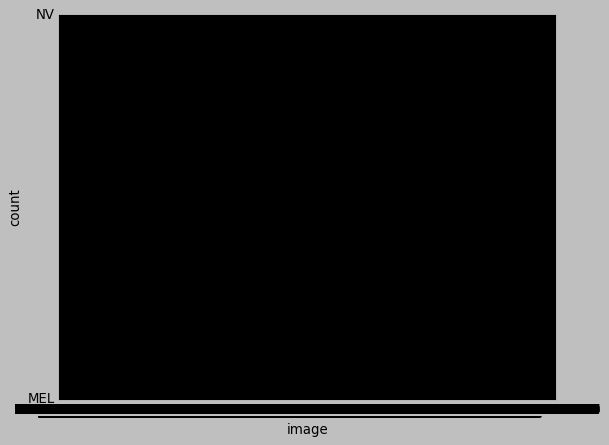

In [5]:
sns.countplot(df_labels["label"])
plt.show()

In [6]:
import numpy as np
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']),
    y=df_labels["label"].values
)

class_wt_dict = dict(zip(np.array(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']), class_weights))
print(class_wt_dict)


{np.str_('AKIEC'): np.float64(4.375273044997815), np.str_('BCC'): np.float64(2.78349082823791), np.str_('BKL'): np.float64(1.301832835044846), np.str_('DF'): np.float64(12.440993788819876), np.str_('MEL'): np.float64(1.2854575792581184), np.str_('NV'): np.float64(0.21338020666879728), np.str_('VASC'): np.float64(10.075452716297788)}


In [7]:
class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: np.float64(4.375273044997815),
 1: np.float64(2.78349082823791),
 2: np.float64(1.301832835044846),
 3: np.float64(12.440993788819876),
 4: np.float64(1.2854575792581184),
 5: np.float64(0.21338020666879728),
 6: np.float64(10.075452716297788)}

In [8]:
from tqdm import tqdm
HAM_images="C:/Users/pruth/Downloads/dataset/ham10000_combined"

images = os.listdir(HAM_images)

for image in tqdm(images):
    
    fname=image[:-4]
    label=df_labels.loc[fname, "label"]
    src = os.path.join(HAM_images, image)
    dst = os.path.join('HAM_Dataset', label, image)
    shutil.copyfile(src, dst)

100%|██████████| 10015/10015 [00:13<00:00, 752.85it/s]


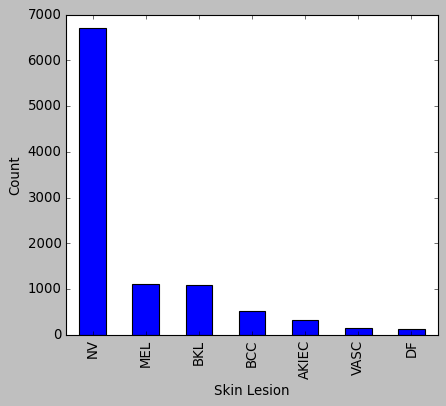

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize = (6, 5))
df_labels['label'].value_counts().plot(kind='bar', ax=ax1)
plt.ylabel('Count')
plt.xlabel('Skin Lesion')
plt.show()

### Train Test Split

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess


image_gen = ImageDataGenerator(preprocessing_function=vgg_preprocess, validation_split=0.15)

In [11]:
data_dir = 'HAM_Dataset'
batch_size = 128
target_size = (224,224)
train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(test_image_gen.class_indices)

Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


##     

## Transfer Learning using VGG16 Model

In [12]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_model.layers[:-1]:
    layer.trainable = False

x = vgg16_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
tl_model = Model(inputs=vgg16_model.input, outputs=x)


tl_model.summary()
tl_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,563,847 (105.15 MB)

 Trainable params: 12,849,159 (49.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Model Training

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint(
    'best_model_aug1.keras',
    save_best_only=True,
    monitor='val_accuracy',
    verbose=1
)

callback_list = [model_chkpt, lr_reduce]


callback_list = [model_chkpt,lr_reduce]

In [14]:
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

c:\Users\pruth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.2825 - loss: 21.9284
Epoch 1: val_accuracy improved from None to 0.55037, saving model to best_model_aug1.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 688s 10s/step - accuracy: 0.3152 - loss: 10.2181 - val_accuracy: 0.5504 - val_loss: 1.2559 - learning_rate: 0.0010
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3958 - loss: 1.5410
Epoch 2: val_accuracy did not improve from 0.55037
67/67 ━━━━━━━━━━━━━━━━━━━━ 698s 10s/step - accuracy: 0.3909 - loss: 1.4698 - val_accuracy: 0.5397 - val_loss: 1.2003 - learning_rate: 0.0010
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3751 - loss: 1.3647
Epoch 3: val_accuracy did not improve from 0.55037

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
67/67 ━━━━━━━━━━━━━━━━━━━━ 683s 10s/step - accuracy: 0.3828 - loss: 1.3184 - val_accuracy: 0.5410 - val_loss: 1.1782 - learning_rate: 0.0010
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accur

### Model Evaluation

In [ ]:
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist2.csv')

<Axes: >

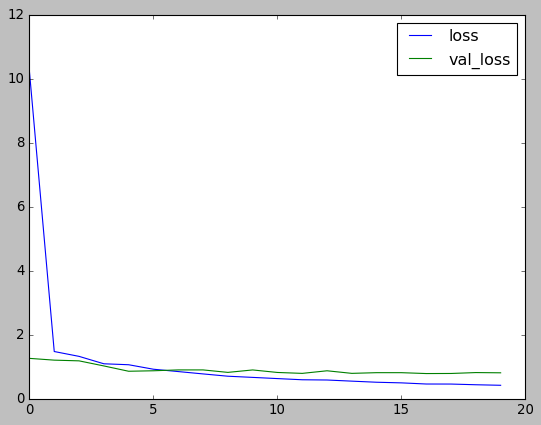

In [16]:
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

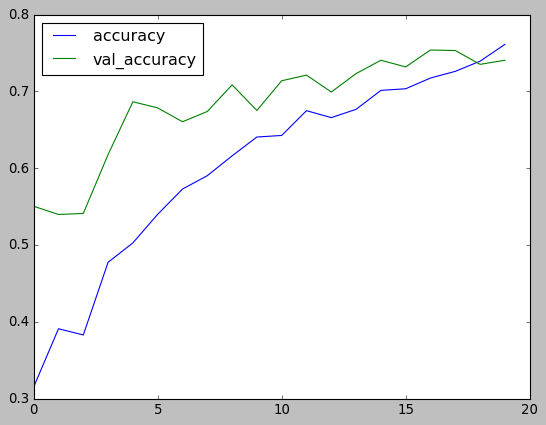

In [17]:
metrics[["accuracy","val_accuracy"]].plot()

In [18]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [19]:
MODEL_PATH = r"C:\Users\pruth\Downloads\project3\best_model_aug1.keras"   # change if your filename differs

if os.path.exists(MODEL_PATH):
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully from:", MODEL_PATH)
else:
    print("⚠️ Model not found! Please train and save it first.")


✅ Model loaded successfully from: C:\Users\pruth\Downloads\project3\best_model_aug1.keras


In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_image_gen = test_datagen.flow_from_directory(
    r"C:\Users\pruth\Downloads\project3\HAM_Dataset",         # <-- update this to your test folder path
    target_size=(224, 224), # same as training size
    batch_size=16,
    class_mode='categorical',  # or 'binary' if 2 classes
    shuffle=False
)


Found 10015 images belonging to 7 classes.


In [21]:
loss, acc = model.evaluate(test_image_gen)
print(f"✅ Test Accuracy: {acc*100:.2f}%")
print(f"Loss: {loss:.4f}")


c:\Users\pruth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


626/626 ━━━━━━━━━━━━━━━━━━━━ 708s 1s/step - accuracy: 0.1307 - loss: 1.6410
✅ Test Accuracy: 13.07%
Loss: 1.6410


In [22]:
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

test_labels = test_image_gen.classes

626/626 ━━━━━━━━━━━━━━━━━━━━ 710s 1s/step


In [23]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, predictions)

In [24]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.99610895 0.         0.         0.00389105
  0.        ]
 [0.         0.         0.99818016 0.         0.         0.00181984
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.97882177 0.         0.         0.02117823
  0.        ]
 [0.         0.         0.97887324 0.         0.         0.02112676
  0.        ]]


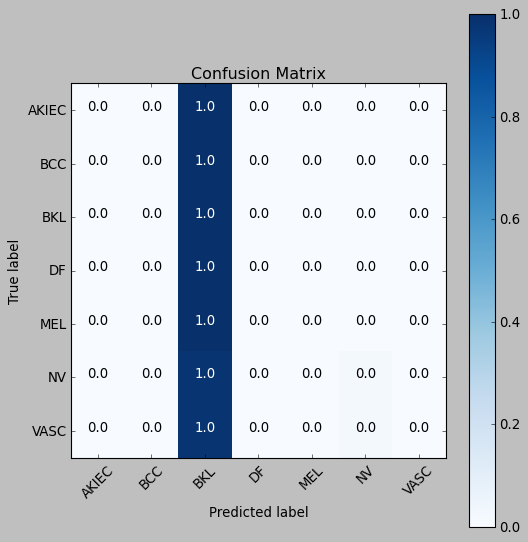

In [25]:
cm_plot_labels = list(test_image_gen.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)

In [26]:
print(classification_report(test_image_gen.classes, predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       327
           1       0.00      0.00      0.00       514
           2       0.11      1.00      0.20      1099
           3       0.00      0.00      0.00       115
           4       0.00      0.00      0.00      1113
           5       0.95      0.02      0.04      6705
           6       0.00      0.00      0.00       142

    accuracy                           0.12     10015
   macro avg       0.15      0.15      0.03     10015
weighted avg       0.65      0.12      0.05     10015



In [27]:
# === Prediction & Evaluation Section ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


In [28]:
# Create test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    r"C:\Users\pruth\Downloads\project3\HAM_Dataset",          # ⚠️ change to your test folder path
    target_size=(224, 224),  # same as VGG16 input
    batch_size=16,
    class_mode='categorical',  # use 'binary' if only 2 classes
    shuffle=False
)


Found 10015 images belonging to 7 classes.


c:\Users\pruth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


626/626 ━━━━━━━━━━━━━━━━━━━━ 692s 1s/step

✅ Test Accuracy: 13.07%

Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.00      0.00      0.00       327
         BCC       0.00      0.00      0.00       514
         BKL       0.11      0.99      0.20      1099
          DF       0.00      0.00      0.00       115
         MEL       0.00      0.00      0.00      1113
          NV       0.93      0.03      0.06      6705
        VASC       0.00      0.00      0.00       142

    accuracy                           0.13     10015
   macro avg       0.15      0.15      0.04     10015
weighted avg       0.64      0.13      0.06     10015



c:\Users\pruth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pruth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pruth\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


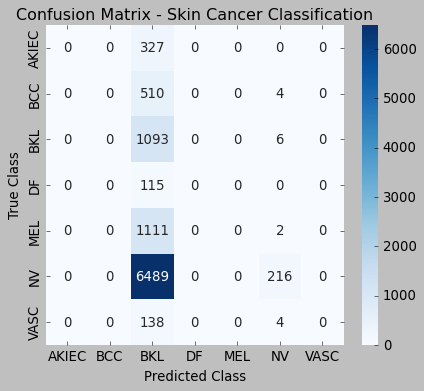

In [29]:
# Predict on test dataset
pred_probs = model.predict(test_gen, verbose=1)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes

# Map class indices
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Convert indices to labels
pred_labels = [idx_to_class[i] for i in pred_classes]
true_labels = [idx_to_class[i] for i in true_classes]

# Calculate accuracy
acc = accuracy_score(true_classes, pred_classes)
print(f"\n✅ Test Accuracy: {acc*100:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(true_classes, pred_classes, target_names=list(idx_to_class.values())))

# Confusion matrix
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=idx_to_class.values(), yticklabels=idx_to_class.values())
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix - Skin Cancer Classification")
plt.show()


In [31]:
# Save predictions to CSV for reference
filenames = test_gen.filenames
top_probs = pred_probs.max(axis=1)

df = pd.DataFrame({
    "filename": filenames,
    "true_label": true_labels,
    "pred_label": pred_labels,
    "confidence": top_probs,
    "correct": (true_classes == pred_classes)
})

df.to_csv("skin_cancer_predictions.csv", index=False)
print("💾 Predictions saved to 'skin_cancer_predictions.csv'")


💾 Predictions saved to 'skin_cancer_predictions.csv'


In [32]:
#image_path=r"C:\Users\pruth\Downloads\project3\HAM_Dataset\MEL\ISIC_0033942.jpg"
def predict_single_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    preds = model.predict(x)[0]
    pred_class = np.argmax(preds)
    class_name = list(test_gen.class_indices.keys())[pred_class]
    print(f"\n🔍 Predicted Cancer Type: {class_name}")
    print(f"Class Probabilities: {preds}")


# Example usage:
predict_single_image(r"C:\Users\pruth\Downloads\project3\HAM_Dataset\BCC\ISIC_0034026.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step

🔍 Predicted Cancer Type: BKL
Class Probabilities: [0.06545072 0.07997565 0.40317374 0.131428   0.1152539  0.15432891
 0.05038904]


In [33]:
from tensorflow.keras.models import Model
model.save("vgg16_model.h5")
print("VGG16 model saved successfully.")


VGG16 model saved successfully.
